In [1]:
import itertools
import networkx as nx
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

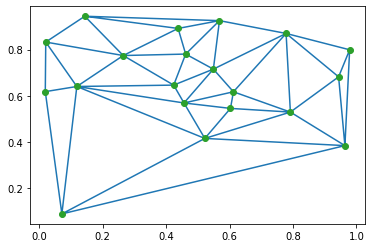

In [2]:
n = 20
seed = 0
np.random.seed(seed)
coordinates = np.random.uniform(0, 1, 2*n)
points = coordinates.reshape(-1, 2)
triangulation = Delaunay(points)
plt.triplot(points[:,0], points[:,1], triangulation.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.savefig("Delaunnay.png", dpi=300)

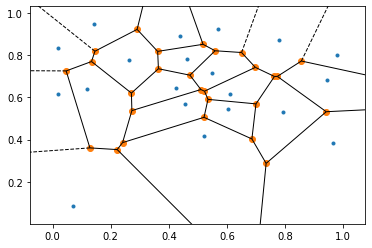

In [3]:
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.savefig("Voronoi.png", dpi=300)

In [4]:
def GabrielViaBruteforce(n, seed=None):
    gabrielGraph = nx.complete_graph(n)
    np.random.seed(seed)
    coordinates = np.random.uniform(0, 1, 2*n)
    points = coordinates.reshape(-1, 2)
    
    triples = itertools.product(range(n), repeat=3)
    for triple in triples:
        if (len(set(triple)) != 3) or (triple[0] not in gabrielGraph.neighbors(triple[1])): continue
        p1 = points[triple[0]]
        p2 = points[triple[1]]
        p3 = points[triple[2]]
        center = 0.5 * (p1 + p2)
        radius = 0.5 * np.linalg.norm(p2-p1)
        if (np.linalg.norm(p3-center) <= radius):
            gabrielGraph.remove_edge(triple[0], triple[1])
            
    nx.draw_networkx_nodes(gabrielGraph, points, node_size=10)
    nx.draw_networkx_edges(gabrielGraph, points, width=0.2)
    #plt.savefig("Gabriel.png", dpi=300)
    
def DelaunayGraph(points):
    tri = Delaunay(points)
    G = nx.Graph()
    
    indptr = tri.vertex_neighbor_vertices[0]
    indices = tri.vertex_neighbor_vertices[1]
    for i in range(len(points)):
        for j in indices[indptr[i]:indptr[i+1]]:
            if i < j:
                G.add_edge(i, j)
                
    return G
    
def GabrielViaDelaunay(n, seed=None):
    np.random.seed(seed)
    coordinates = np.random.uniform(0, 1, 2*n)
    points = coordinates.reshape(-1, 2)
    gabrielGraph = DelaunayGraph(points)
    
    for e in gabrielGraph.edges():
        for other in gabrielGraph.nodes():
            if other not in e:
                p1 = points[e[0]]
                p2 = points[e[1]]
                p3 = points[other]
                center = 0.5 * (p1 + p2)
                radius = 0.5 * np.linalg.norm(p2-p1)
                if (np.linalg.norm(p3-center) <= radius):
                    gabrielGraph.remove_edge(e[0], e[1])
                    break
    nx.draw_networkx_nodes(gabrielGraph, points, node_size=10)
    nx.draw_networkx_edges(gabrielGraph, points, width=0.2)
    #plt.savefig("Gabriel.png", dpi=300)
    
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def GabrielViaDelaunayVoronoi(n, seed=None):
    
    np.random.seed(seed)
    coordinates = np.random.uniform(0, 1, 2*n)
    points = coordinates.reshape(-1, 2)
    
    delaunayGraph = DelaunayGraph(points)
    voronoiDiagram = Voronoi(points)
    voronoiVertices = voronoiDiagram.vertices
    voronoiCenter = voronoiDiagram.points.mean(axis=0)
    ptp_bound = voronoiDiagram.points.ptp(axis=0)
    
    gabrielGraph = nx.Graph()
    for u, v in delaunayGraph.edges():
        uRegion = set(voronoiDiagram.regions[voronoiDiagram.point_region[u]])
        vRegion = set(voronoiDiagram.regions[voronoiDiagram.point_region[v]])
        boundary = sorted(list(uRegion.intersection(vRegion)))
        boundaryVertices = [None, voronoiVertices[boundary[1]]]
        
        if (boundary[0] == -1):
            tangent = points[u] - points[v]
            tangent /= np.linalg.norm(tangent)
            normal = np.array([-tangent[1], tangent[0]])
            
            midPoint = 0.5 * (points[u] + points[v])
            direction = np.sign(np.dot(midPoint - voronoiCenter, normal)) * normal
            farPoint = voronoiVertices[boundary[1]] + direction * ptp_bound.max()
            boundaryVertices[0] = farPoint
        else:
            boundaryVertices[0] = voronoiVertices[boundary[0]]
        
        if intersect(points[u], points[v], boundaryVertices[0], boundaryVertices[1]): 
            gabrielGraph.add_edge(u, v)
    
    nx.draw_networkx_nodes(gabrielGraph, points, node_size=10)
    nx.draw_networkx_edges(gabrielGraph, points, width=0.2)
    plt.savefig("Gabriel.png", dpi=300)

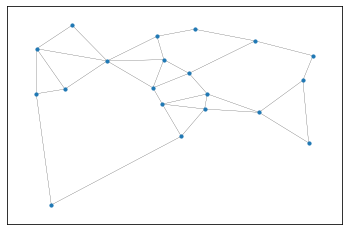

In [5]:
GabrielViaDelaunayVoronoi(20, seed=0)

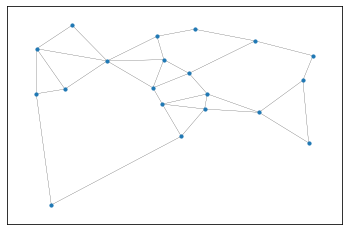

In [6]:
GabrielViaBruteforce(20, seed=0)

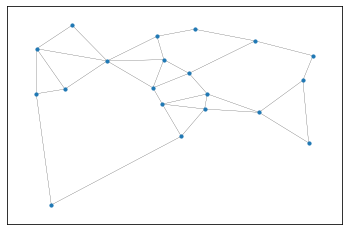

In [7]:
GabrielViaDelaunay(20, seed=0)